# Training a simple CNN model in `keras` (>3.0) for Tornado Detection

This notebook steps through how to train a simple CNN model using a subset of TorNet.

This will not produce a model with any skill, but simply provides a working end-to-end example of how to set up a data loader, build, and fit a model


In [1]:
import os
os.environ['KERAS_BACKEND']='tensorflow' # set to 'tensorflow', 'torch' or 'jax' (installs required)

In [2]:
import sys
# Uncomment if tornet isn't installed in your environment or in your path already
#sys.path.append('../')  

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras

from tornet.data.tf.loader import create_tf_dataset 
from tornet.data.constants import ALL_VARIABLES

In [7]:
# keras accepts most data loaders (tensorflow, torch).
# A pure keras data loader, with necessary preprocessing steps for the cnn baseline, is provided
from tornet.data.keras.loader import KerasDataLoader
data_root = "C:/Users/mjhig/tornet_2013"
ds = KerasDataLoader(data_root=data_root,
                     data_type='train',
                     years=[2013,2014],
                     batch_size = 8, 
                     workers = 4,
                     use_multiprocessing = True)


In [71]:
ALL_VARIABLES=['DBZ',
               'VEL',
               'KDP',
               'RHOHV',
               'ZDR',
               'WIDTH'
               ]

In [89]:
# Create a simple CNN model
# This normalizes data, concatenates along channel, and applies a Conv2D
from tornet.data.constants import CHANNEL_MIN_MAX
from tornet.models.keras.layers import FillNaNs

input_vars = ALL_VARIABLES # which variables to use

# TF convention is B,L,W,H
inputs = {v:keras.Input(shape=(120,240,2),name=v) for v in input_vars}

# Normalize inputs
norm_layers = []
for v in input_vars:
    min_max = np.array(CHANNEL_MIN_MAX[v]) # [2,]

    # choose mean,var to get approximate [-1,1] scaling
    var=((min_max[1]-min_max[0])/2)**2 # scalar
    var=np.array(2*[var,])    # [n_sweeps,]
    offset=(min_max[0]+min_max[1])/2    # scalar
    offset=np.array(2*[offset,]) # [n_sweeps,]
    
    norm_layers.append(
        keras.layers.Normalization(mean=offset, variance=var,
                                   name='Normalized_%s' % v)
    )

# Concatenate normed inputs along channel dimension
x=keras.layers.Concatenate(axis=-1,name='Concatenate1')(
        [l(inputs[v]) for l,v in zip(norm_layers,input_vars)]
        )

# Replace background (nan) with -3
x = FillNaNs(fill_val=-3,name='ReplaceNan')(x)

# Processing
x = keras.layers.Conv2D(32,3,padding='same',activation='relu')(x)
x = keras.layers.Conv2D(1,1,padding='same',activation='relu',name='TornadoLikelihood')(x)
y = keras.layers.GlobalMaxPool2D(name='GlobalMaxPool')(x)

model = keras.Model(inputs=inputs,outputs=y,name='TornadoDetector')

model.summary()

Model: "TornadoDetector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ DBZ (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VEL (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ KDP (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RHOHV (InputLayer)  │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ZDR (InputLayer)    │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ WIDTH (InputLayer)  │ (None, 120, 240,  │          0 │ -                 │
│                     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_DBZ      │ (None, 120, 240,  │          0 │ DBZ[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_VEL      │ (None, 120, 240,  │          0 │ VEL[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_KDP      │ (None, 120, 240,  │          0 │ KDP[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_RHOHV    │ (None, 120, 240,  │          0 │ RHOHV[0][0]       │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_ZDR      │ (None, 120, 240,  │          0 │ ZDR[0][0]         │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Normalized_WIDTH    │ (None, 120, 240,  │          0 │ WIDTH[0][0]       │
│ (Normalization)     │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Concatenate1        │ (None, 120, 240,  │          0 │ Normalized_DBZ[0… │
│ (Concatenate)       │ 12)               │            │ Normalized_VEL[0… │
│                     │                   │            │ Normalized_KDP[0… │
│                     │                   │            │ Normalized_RHOHV… │
│                     │                   │            │ Normalized_ZDR[0… │
│                     │                   │            │ Normalized_WIDTH… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ isnan_8 (Isnan)     │ (None, 120, 240,  │          0 │ Concatenate1[0][… │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ where_8 (Where)     │ (None, 120, 240,  │          0 │ isnan_8[0][0],    │
│                     │ 12)               │            │ Concatenate1[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 3,521 (13.75 KB)

 Trainable params: 3,521 (13.75 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Compile
opt  = keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
loss=keras.losses.BinaryFocalCrossentropy()
model.compile(loss=loss, optimizer=opt)

In [91]:
# Train
# steps_per_epoch=10 for demo purposes
model.fit(ds,epochs=3,steps_per_epoch=10)

Epoch 1/3


c:\Users\mjhig\anaconda3\envs\tornet-torch\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: {'DBZ': 'DBZ', 'VEL': 'VEL', 'KDP': 'KDP', 'RHOHV': 'RHOHV', 'ZDR': 'ZDR', 'WIDTH': 'WIDTH'}. Received: the structure of inputs={'DBZ': '*', 'VEL': '*', 'KDP': '*', 'RHOHV': '*', 'ZDR': '*', 'WIDTH': '*', 'range_folded_mask': '*', 'label': '*', 'category': '*', 'event_id': '*', 'ef_number': '*', 'az_lower': '*', 'az_upper': '*', 'rng_lower': '*', 'rng_upper': '*', 'time': '*', 'tornado_start_time': '*', 'tornado_end_time': '*', 'coordinates': '*'}
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 49s 887ms/step - loss: 32.7096
Epoch 2/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - loss: 0.3970 
Epoch 3/3
10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - loss: 0.5662


In [45]:
# Build a test set
ds_test = KerasDataLoader(data_root=data_root,
                         data_type='test',
                         years=[2018],
                         batch_size = 8, 
                         workers = 4,
                         use_multiprocessing = True)


In [107]:
import random

def get_random_batch(dataset):
    dataset_iter = iter(dataset)
    random_index = random.randint(0, 15)  # Pick a random batch index
    for _ in range(random_index):
        next(dataset_iter)  # Skip batches until reaching the random one
    return next(dataset_iter)  # Return the randomly selected batch

sample_batch = get_random_batch(ds_test)
sample_input, sample_labels = sample_batch

Visualizing these layers: ['conv2d_13']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step


c:\Users\mjhig\anaconda3\envs\tornet-torch\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: {'DBZ': 'DBZ', 'VEL': 'VEL', 'KDP': 'KDP', 'RHOHV': 'RHOHV', 'ZDR': 'ZDR', 'WIDTH': 'WIDTH'}. Received: the structure of inputs={'DBZ': '*', 'VEL': '*', 'KDP': '*', 'RHOHV': '*', 'ZDR': '*', 'WIDTH': '*', 'range_folded_mask': '*', 'label': '*', 'category': '*', 'event_id': '*', 'ef_number': '*', 'az_lower': '*', 'az_upper': '*', 'rng_lower': '*', 'rng_upper': '*', 'time': '*', 'tornado_start_time': '*', 'tornado_end_time': '*', 'coordinates': '*'}
  warnings.warn(


[0 0 0 0 0 0 0 0]


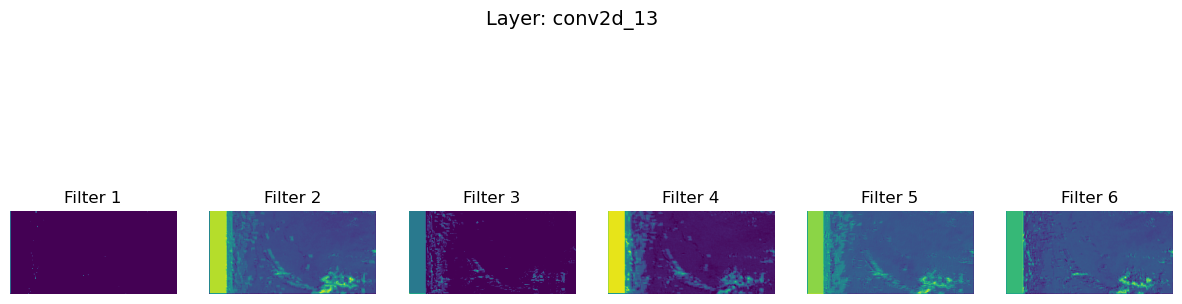

In [108]:
from tensorflow.keras.models import Model
sample_batch = next(iter(ds_test))  # Extracts one batch
sample_input, sample_labels = sample_batch
# Extract Conv2D layers' outputs
layer_outputs = [layer.output for layer in model.layers if 'conv2d' in layer.name]

# Create a new model that outputs activations from those layers
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get layer names
layer_names = [layer.name for layer in model.layers if 'conv2d' in layer.name]

print("Visualizing these layers:", layer_names)
activations = activation_model.predict(sample_input)

import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def plot_activations(activations, layer_names, sample_index=0):
    """Plots the activation maps from convolutional layers"""
    num_layers = min(len(activations), len(layer_names))  # Ensure correct indexing

    for i in range(num_layers):
        activation = activations[i]  # Get activation of the current layer
        
        # Ensure batch dimension is handled
        if activation.ndim == 4:
            activation = np.squeeze(activation[sample_index])  # Select one sample from batch

        if activation.ndim == 2:  # If it's a single-channel image
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(activation, cmap='viridis')
            ax.axis("off")
            ax.set_title(f'Layer: {layer_names[i]} (Single Channel)')
            plt.show()
            continue

        num_filters = activation.shape[-1]  # Number of filters in the layer
        fig, axes = plt.subplots(1, min(num_filters, 6), figsize=(15, 5))  # Show up to 6 filters

        # Ensure axes is iterable
        if min(num_filters, 6) == 1:
            axes = [axes]  

        fig.suptitle(f'Layer: {layer_names[i]}', fontsize=14)

        for j in range(min(num_filters, 6)):  # Show up to 6 feature maps
            axes[j].imshow(activation[:, :, j], cmap='viridis')  # Correct indexing
            axes[j].axis("off")
            axes[j].set_title(f'Filter {j+1}')

        plt.show()

# Call function with activations
print(sample_labels)
plot_activations(activations, layer_names, sample_index=6)  # Select first sample from batch


# Call function with activations
#plot_activations(activations, layer_names)


Visualizing these layers: ['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH', 'Normalized_DBZ', 'Normalized_VEL', 'Normalized_KDP', 'Normalized_RHOHV', 'Normalized_ZDR', 'Normalized_WIDTH', 'Concatenate1', 'conv2d_13']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


c:\Users\mjhig\anaconda3\envs\tornet-torch\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: {'DBZ': 'DBZ', 'VEL': 'VEL', 'KDP': 'KDP', 'RHOHV': 'RHOHV', 'ZDR': 'ZDR', 'WIDTH': 'WIDTH'}. Received: the structure of inputs={'DBZ': '*', 'VEL': '*', 'KDP': '*', 'RHOHV': '*', 'ZDR': '*', 'WIDTH': '*', 'range_folded_mask': '*', 'label': '*', 'category': '*', 'event_id': '*', 'ef_number': '*', 'az_lower': '*', 'az_upper': '*', 'rng_lower': '*', 'rng_upper': '*', 'time': '*', 'tornado_start_time': '*', 'tornado_end_time': '*', 'coordinates': '*'}
  warnings.warn(



Sample Labels: [0 0 0 0 0 0 0 0]


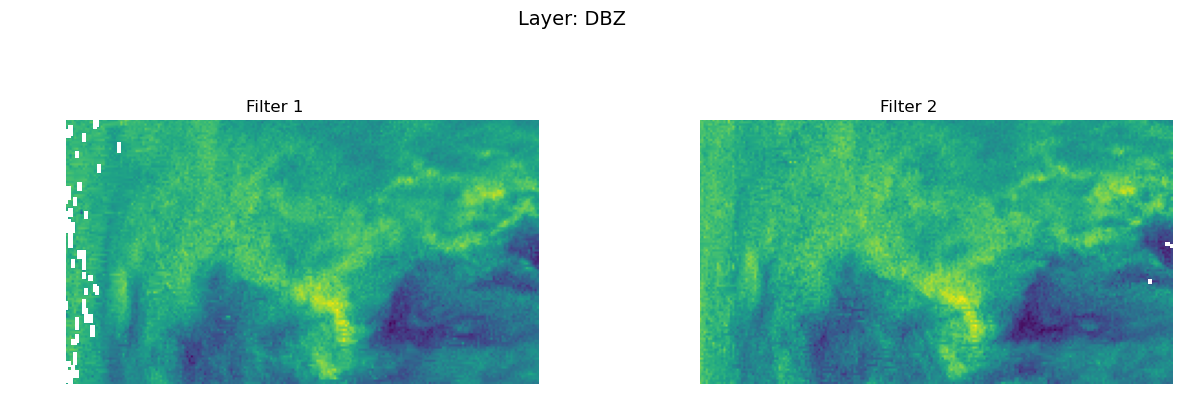

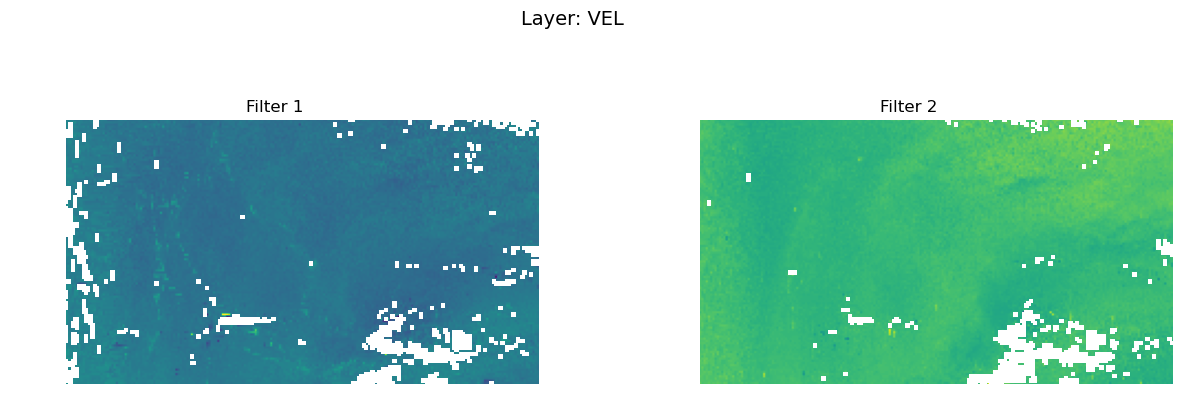

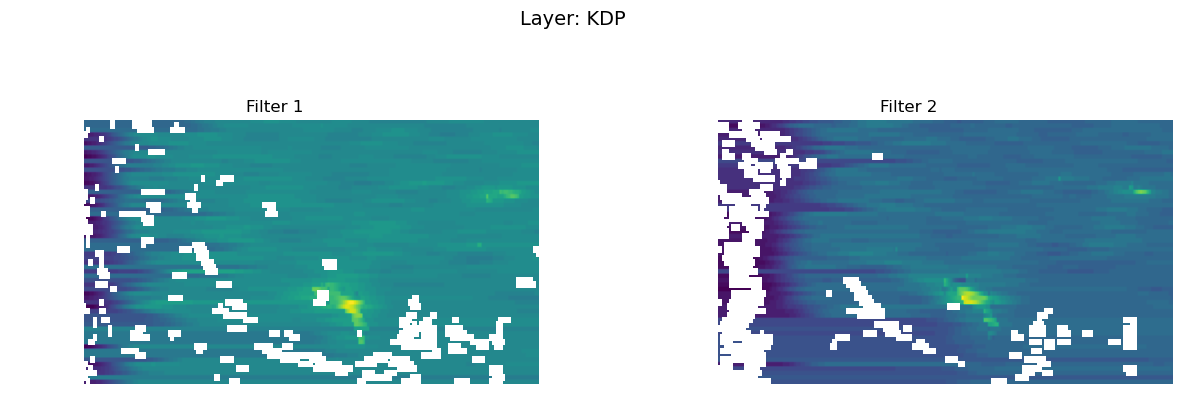

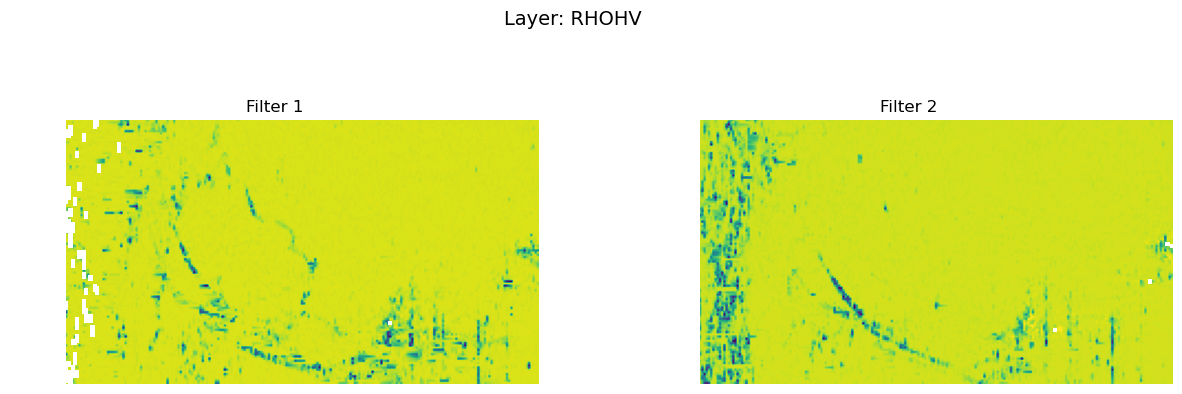

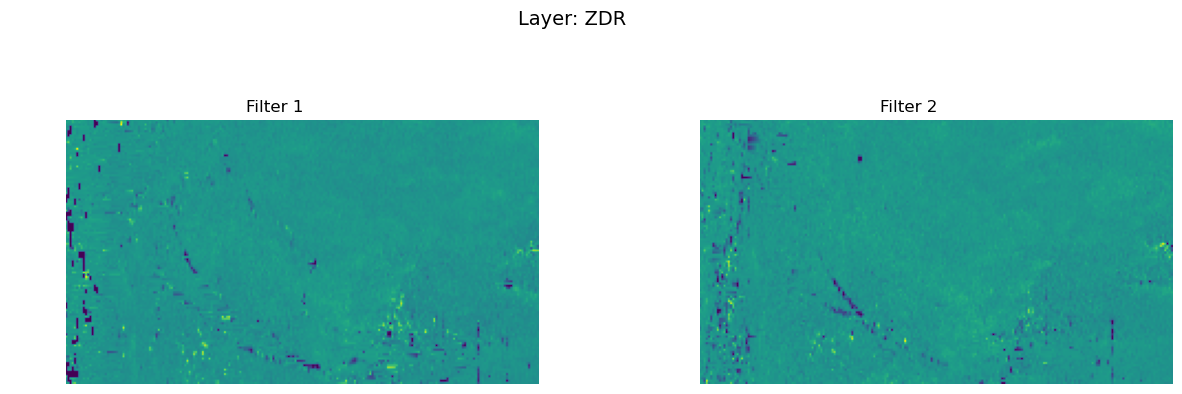

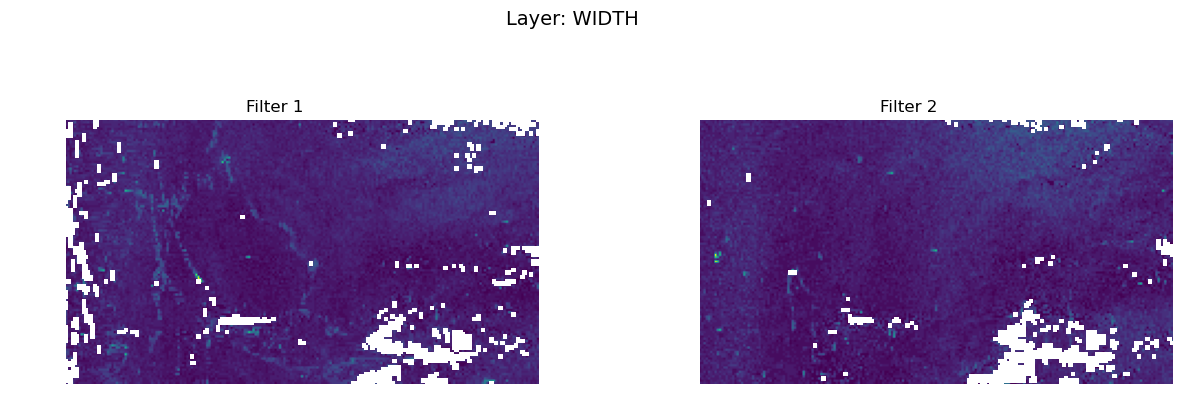

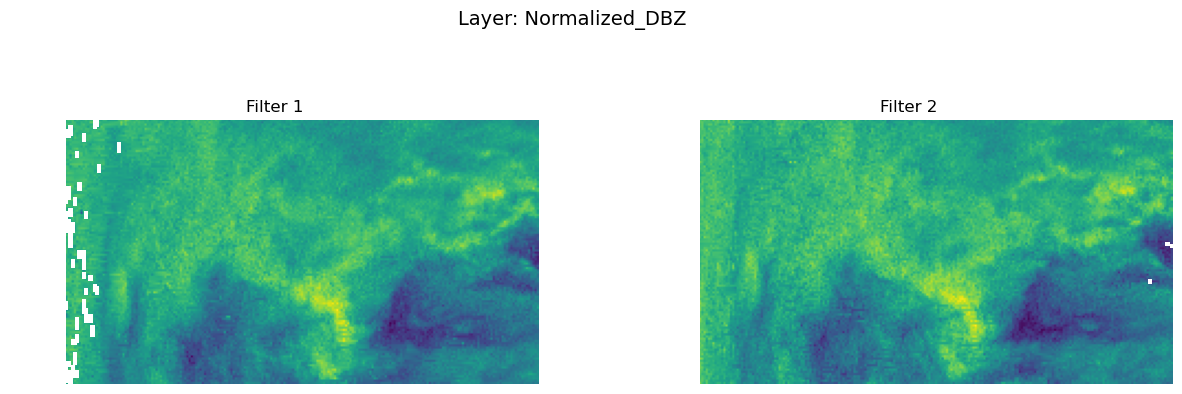

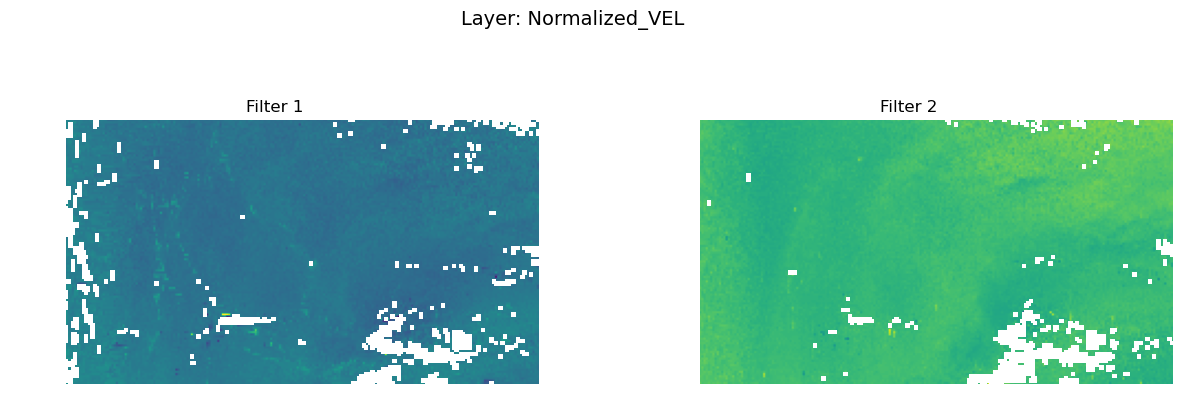

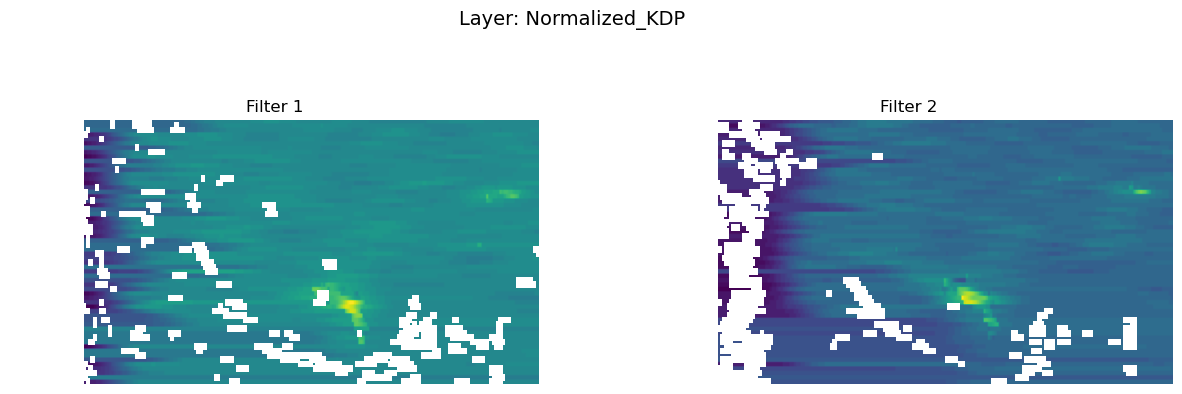

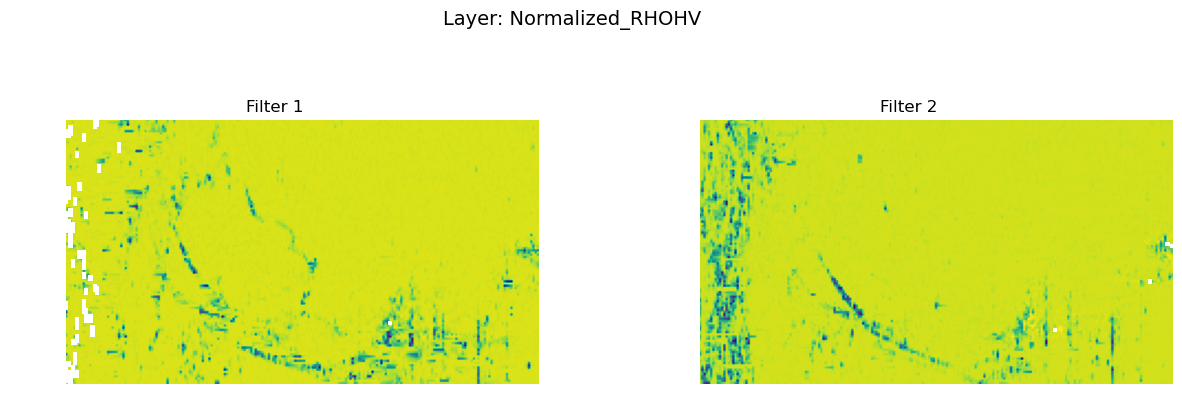

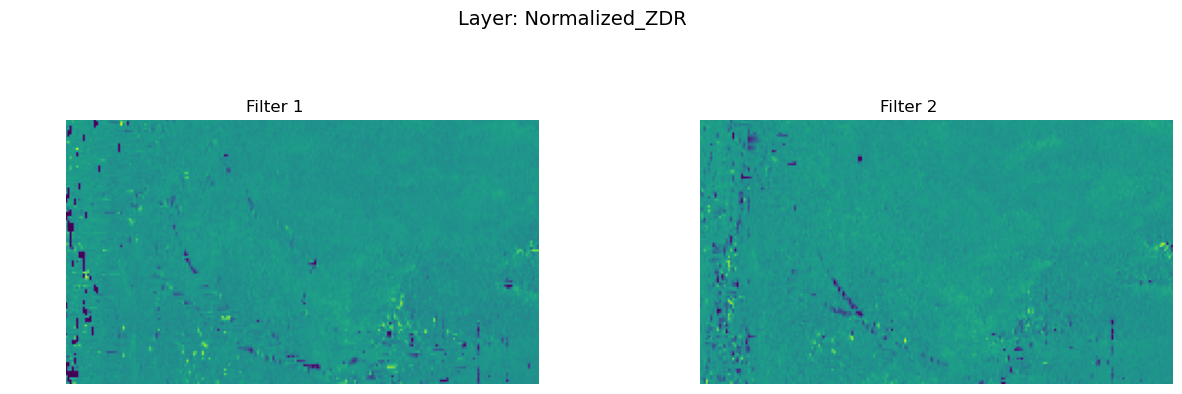

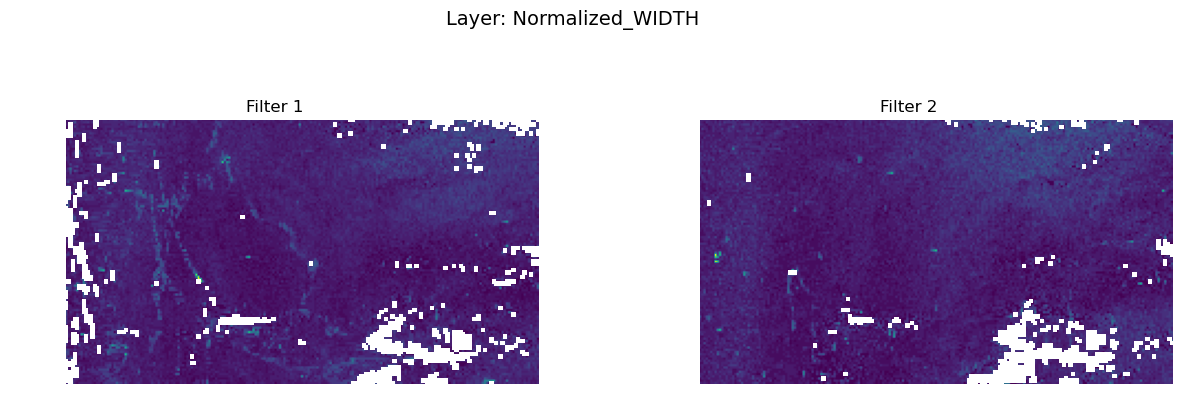

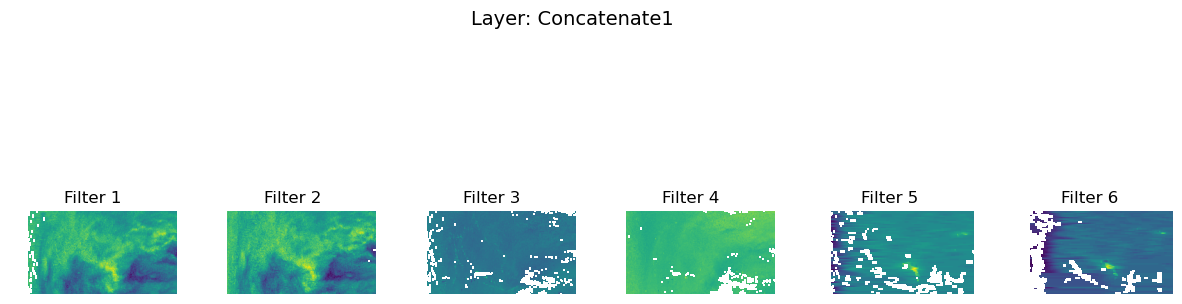

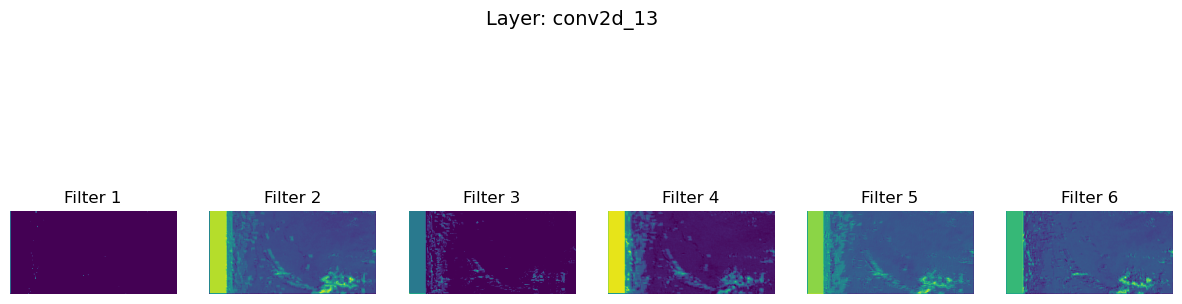

In [ ]:
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Extract all layer outputs
layer_outputs = [layer.output for layer in model.layers]  # Extract outputs for all layers

# Create a model that outputs activations from all layers
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get all layer names
layer_names = [layer.name for layer in model.layers]

print("Visualizing these layers:", layer_names)
def get_random_batch(dataset):
    dataset_iter = iter(dataset)
    random_index = random.randint(0, 15)  # Pick a random batch index
    for _ in range(random_index):
        next(dataset_iter)  # Skip batches until reaching the random one
    return next(dataset_iter)  # Return the randomly selected batch
def get_batch_with_positive(dataset):
    for batch in dataset:
        batch_input, batch_labels = batch
        if sum(batch_labels) > 0:
            return batch  # Return the first batch with a positive sample
    return batch_input, batch_labels   # Return None if no batch contains a positive sample
sample_batch = get_random_batch(ds_test)
sample_input, sample_labels = sample_batch


activations = activation_model.predict(sample_input)



def plot_activations(activations, layer_names, sample_index=0):
    """Plots the activation maps from all layers"""
    num_layers = min(len(activations), len(layer_names))  # Ensure correct indexing

    for i in range(num_layers):
        activation = activations[i]  # Get activation of the current layer
        
        # Ensure batch dimension is handled
        if activation.ndim == 4:  # Conv/Pooling layers
            activation = np.squeeze(activation[sample_index])  # Select one sample from batch

        elif activation.ndim == 2:  # Dense layers (flattened)
            print(f"Layer: {layer_names[i]} - Shape: {activation.shape}")
            plt.figure(figsize=(12, 6),edgecolor='k')
            plt.plot(activation[sample_index])
            plt.title(f'Layer: {layer_names[i]} (Dense Layer Output)')
            plt.show()
            continue  # Skip to next layer

        if activation.ndim == 3:  # 3D feature maps (Conv2D layers)
            num_filters = activation.shape[-1]  # Number of filters in the layer
            fig, axes = plt.subplots(1, min(num_filters, 6), figsize=(15, 5))  # Show up to 6 filters

            if min(num_filters, 6) == 1:
                axes = [axes]  # Make iterable for single filter cases

            fig.suptitle(f'Layer: {layer_names[i]}', fontsize=14)

            for j in range(min(num_filters, 6)):  # Show up to 6 feature maps
                axes[j].imshow(activation[:, :, j], cmap='viridis')  # Correct indexing
                axes[j].axis("off")
                axes[j].set_title(f'Filter {j+1}')

            plt.show()

# Call function with activations
print("\nSample Labels:", sample_labels)
plot_activations(activations, layer_names, sample_index=0)  # Select first sample from batch


In [ ]:
# Evaluate
import tornet.metrics.keras.metrics as km
metrics = [keras.metrics.AUC(from_logits=True,name='AUC'),
           km.BinaryAccuracy(from_logits=True,name='BinaryAccuracy'), 
           ]
model.compile(loss=loss,metrics=metrics)

# steps=10 for demo purposes
model.evaluate(ds_test,steps=10)
